In [1]:
# Code modified and fixed from Stock Technical Analysis with Python
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import talib as ta
import numpy as np
import plotly.plotly as py

In [2]:
df = pd.read_csv("../data/coinbaseBTCUSD_1min_2014-12-01_to_2017-10-20.csv")
df.timestamp = pd.to_datetime(df.timestamp, unit='s') # timestamp is in seconds
df.index = df.timestamp
del df['timestamp']
df = df.loc['2014-12-01T06:00:00':'2017-10-19T23:59:00'] # remove rows that do no lie within the hour window

In [3]:
df.head(1)

,open,high,low,close,volbtc,volusd,wtdprice
timestamp,,,,,,,
2014-12-01 06:00:00,300.0,300.0,300.0,300.0,0.01,3.0,300.0


In [4]:
df.tail(1)

,open,high,low,close,volbtc,volusd,wtdprice
timestamp,,,,,,,
2017-10-19 23:59:00,5703.96,5704.01,5702.87,5704.01,2.489754,14200.042922,5703.392752


In [5]:
# upsample to hourly
hr_df = df.resample(rule = "60Min").agg({'open':'first', 'high':'max', 'low':'min', 'close':'last', 
                                        'volbtc':'sum', 'volusd':'sum', 'wtdprice':'last'})

In [6]:
hr_df.tail()

,open,high,low,close,volbtc,volusd,wtdprice
timestamp,,,,,,,
2017-10-19 19:00:00,5673.11,5673.11,5626.00,5634.96,468.387320,2.648070e+06,5634.950625
2017-10-19 20:00:00,5634.96,5719.49,5634.95,5701.69,557.529716,3.164202e+06,5701.690000
2017-10-19 21:00:00,5701.69,5719.71,5691.09,5719.70,399.429587,2.279203e+06,5719.697723
2017-10-19 22:00:00,5719.70,5730.00,5690.00,5711.71,421.897866,2.412848e+06,5707.476979
2017-10-19 23:00:00,5711.71,5724.99,5689.97,5704.01,277.379961,1.584357e+06,5703.392752


In [7]:
hr_df.describe()

,open,high,low,close,volbtc,volusd,wtdprice
count,24325.000000,24325.000000,24325.000000,24325.000000,24325.000000,2.432500e+04,24325.000000
mean,972.279134,976.970376,966.768851,972.481490,373.079144,4.659577e+05,972.456965
std,1131.419776,1138.376327,1123.862281,1131.811887,550.600701,1.016997e+06,1131.756870
min,114.030000,150.000000,0.060000,113.060000,0.001109,4.188129e+00,139.895000
25%,280.100000,281.000000,279.360000,280.090000,164.423958,6.938169e+04,280.108260
50%,532.460000,534.160000,528.720000,532.550000,265.881857,1.256844e+05,532.535696
75%,1011.810000,1013.940000,1008.000000,1011.820000,434.613093,3.317424e+05,1011.780037
max,5849.100000,5867.000000,5820.190000,5849.100000,31505.461253,2.856359e+07,5849.097036


In [8]:
df = df.resample(rule = "D").agg({'open': 'first', 'high': 'max', 'low': 'min',
                                         'close': 'last', 'volbtc': 'sum', 'volusd': 'sum',
                                         'wtdprice': 'last'})

In [9]:
df.describe()

,open,high,low,close,volbtc,volusd,wtdprice
count,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1.020000e+03,1020.000000
mean,966.435588,994.532824,936.556392,971.587941,8897.206066,1.111218e+07,971.584589
std,1127.262492,1167.907120,1087.771264,1136.858009,7713.617797,1.970727e+07,1136.703264
min,170.000000,210.000000,0.060000,120.000000,0.015000,5.670000e+00,145.000000
25%,280.747500,286.415000,276.325000,281.385000,5111.806560,2.087113e+06,281.652405
50%,470.755000,519.740000,461.780000,497.260000,7139.003995,3.064758e+06,497.146131
75%,1007.350000,1025.300000,962.152500,1008.785000,10202.638978,7.927622e+06,1008.030627
max,5819.130000,5867.000000,5575.550000,5819.130000,165763.024424,1.826598e+08,5819.253635


In [10]:
# 2017- data
df = df['1-1-2017':].copy()
# bollinger bands
df['bb_up'], df['bb_mid'], df['bb_low'] = ta.BBANDS(np.asarray(df.close), timeperiod=7, 
                                                    nbdevup=1.5, nbdevdn=1.5, matype=0)
# rsi
df['rsi'] = ta.RSI(np.asarray(df.close), timeperiod=14)

In [11]:
### TRADING SIGNAL (buy=1 , sell=-1, hold=0)
# price cross over BB and RSI cross over threshold
# backteset BB to avoid back-testing bias
df['close_lag1'] = df.close.shift(1)
df['bb_low_lag1'] = df.bb_low.shift(1)
df['bb_up_lag1'] = df.bb_up.shift(1)
df['close_lag2'] = df.close.shift(2)
df['bb_low_lag2'] = df.bb_low.shift(2)
df['bb_up_lag2'] = df.bb_up.shift(2)
df['rsi_lag1'] = df.rsi.shift(1)

In [36]:
# generate trading signals
df['bb_sig'] = 0  # default to do nothing
# TODO: refine until the signals look right!!!!
# if lag2 price is less than lag2 bb lower and the oppostive for lag1 values, then buy signal
df.loc[(df.close_lag2 < df.bb_low_lag2) & (df.close_lag1 < df.bb_low_lag1) & (df.rsi_lag1 < 40), 'bb_sig'] = 1
# if lag2 price is less than lag2 bb upper and the oppostite for lag1 values, then sell signal
df.loc[(df.close_lag2 > df.bb_up_lag2) & (df.close_lag1 > df.bb_up_lag1) & (df.rsi_lag1 > 80), 'bb_sig'] = -1

In [37]:
### TRADING STRATEGY
# own asset=1, not own asset=0
df['bb_rsi_str'] = 1
bb_rsi_str = 0
for i, r in enumerate(df.iterrows()):
    if r[1]['bb_sig'] == 1:
        bb_rsi_str = 1
    elif r[1]['bb_sig'] == -1:
        bb_rsi_str = 0
    else:
        bb_rsi_str = df.bb_rsi_str[i-1]
    df.iloc[i, df.columns.get_loc('bb_rsi_str')] = bb_rsi_str

In [38]:
### ANALYSIS
# Strategies Daily Returns
# Bands Crossover Strategy Without Trading Commissions
df['bb_rsi_returns'] = ((df.close / df.close_lag1) - 1) * df.bb_rsi_str
df.iloc[0, df.columns.get_loc('bb_rsi_returns')] = 0.0  # no return for the first period
# Buy and Hold Strategy
df['bh_returns'] = (df.close / df.close_lag1) - 1
df.iloc[0, df.columns.get_loc('bh_returns')] = 0.0  # no return for the first period

# Strategies Cumulative Returns
# Cumulative Returns Calculation
df['bb_rsi_cum_returns'] = (np.cumprod(df.bb_rsi_returns + 1) - 1)
df['bh_cum_returns'] = (np.cumprod(df.bh_returns + 1) - 1)

# Strategies Performance Metrics
# Annualized Returns
# TODO: look at data to determine what should be used.
bb_rsi_yr_returns = df.bb_rsi_cum_returns.tail(1).values[0]
bh_yr_returns = df.bh_cum_returns.tail(1).values[0]
# Annualized Standard Deviation
bb_rsi_std = np.std(df.bb_rsi_returns.values) * np.sqrt(365.)  # cryptos trade 365
bh_std = np.std(df.bh_returns.values) * np.sqrt(365.)
# Annualized Sharpe Ratio
bb_rsi_sharpe = bb_rsi_yr_returns / bb_rsi_std
bh_sharpe = bh_yr_returns / bh_std

# Summary Results Data Table
summary_df = pd.DataFrame({'Summary': ['Return', 'Std Dev', 'Sharpe (Rf=0%)'],
                           'Trade': [bb_rsi_yr_returns, bb_rsi_std, bb_rsi_sharpe],
                           'Buy&Hold': [bh_yr_returns, bh_std, bh_sharpe]})
summary_df = summary_df[['Summary', 'Trade', 'Buy&Hold']]
with pd.option_context('display.precision', 2):
    print(summary_df)

          Summary  Trade  Buy&Hold
0          Return   5.23      4.74
1         Std Dev   0.66      0.87
2  Sharpe (Rf=0%)   7.94      5.45


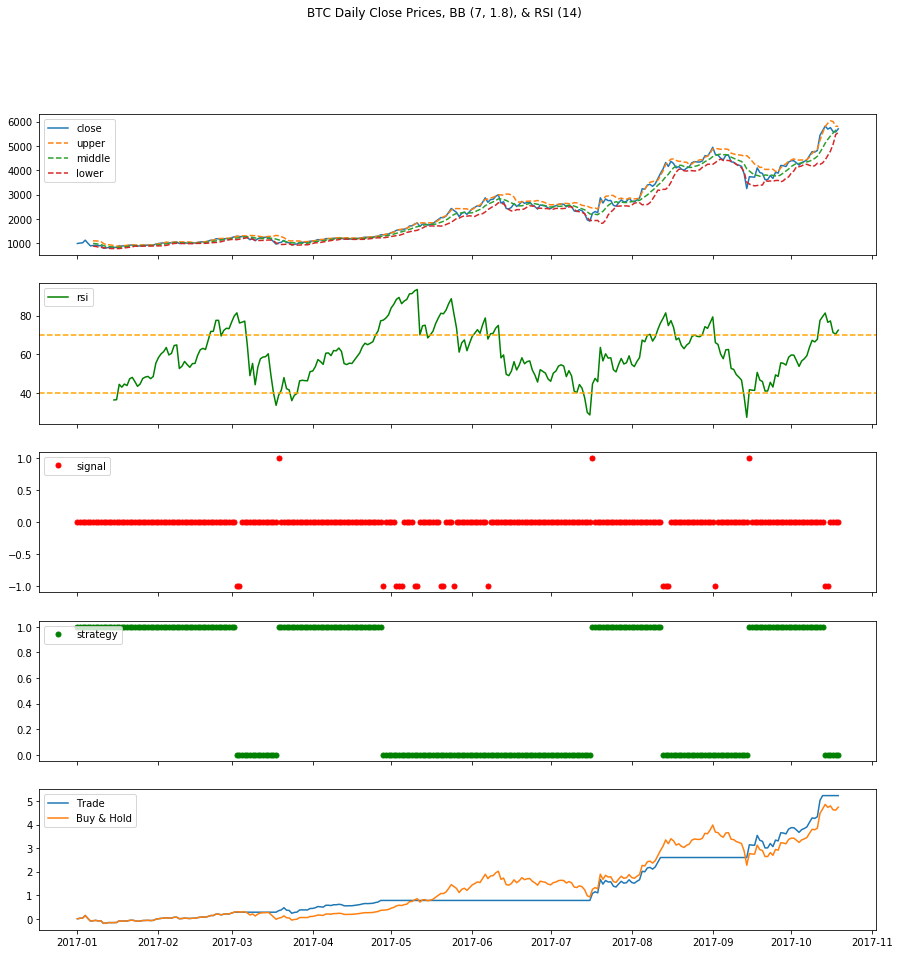

In [39]:
### CHARTING
fig1, ax = plt.subplots(5, sharex=True)
fig1.set_size_inches(15,15)
ax[0].plot(df.close)
ax[0].plot(df.bb_up, linestyle='--', label='upper')
ax[0].plot(df.bb_mid, linestyle='--', label='middle')
ax[0].plot(df.bb_low, linestyle='--', label='lower')
ax[0].legend(loc='upper left')
ax[1].plot(df.rsi, color='green', label='rsi')
ax[1].axhline(y=70, linestyle='--', color='orange')
ax[1].axhline(y=40, linestyle='--', color='orange')
ax[1].legend(loc='upper left')
ax[2].plot(df.bb_sig, marker='o', markersize=5, linestyle='', label='signal', color='red')
ax[2].legend(loc='upper left')
ax[3].plot(df.bb_rsi_str, marker='o', markersize=5, linestyle='', label='strategy', color='green')
ax[3].legend(loc='upper left')
ax[4].plot(df.bb_rsi_cum_returns, label='Trade')
ax[4].plot(df.bh_cum_returns, label='Buy & Hold')
ax[4].legend(loc='upper left')
plt.suptitle('BTC Daily Close Prices, BB (7, 1.5), & RSI (14)')
plt.show()